# **Physics Informed Neural Network (PINN) in Tensorflow**
## This file is a brief documentation of the Python code.

The following cells will demonstrate how the tensorflow code works via a dry run through small snippets of code in sequence.

### The first snippet stands for *importing all necessary libraries..*

In [1]:
import sys
sys.path.insert(0, '../../Utilities/')
print(sys.version)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]


Note that there are 2 important data handling and numerical calculation libraries: **numpy** and **scipy** alongside tensorflow. *Matplotlib* is necessary to plot and visualize data.

Then we plant tensorflow random seed for initialization.

In [2]:
np.random.seed(1234)
tf.set_random_seed(1234)

## Now we *Define the Class* where we are going to use PINNs:

In [3]:
class PINN:
    # Initialize the class
    def __init__(self, P_back, x, P, rho, u, E, layers):
        
        # Create Input Matrix for the given training data point
        X = np.concatenate([P_back, x], 1)
        
        # min & max for normalization
        self.lb = X.min(0)
        self.ub = X.max(0)
        
        # class attribute definitions
        self.X = X
        self.P_back = P_back
        self.x = x
        self.P = P
        self.rho = rho
        self.u = u
        self.E = E
    
        self.layers = layers
        
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)        
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        # define tensors for each variable using tf.placeholder
        self.P_back_tf = tf.placeholder(tf.float32, shape=[None, self.P_back.shape[1]])
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.P_tf = tf.placeholder(tf.float32, shape=[None, self.P.shape[1]])
        self.rho_tf = tf.placeholder(tf.float32, shape=[None, self.rho.shape[1]])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        self.E_tf = tf.placeholder(tf.float32, shape=[None, self.E.shape[1]])
        
        # Predict the values of output by a single forward propagation
        # Also get AutoDiff coefficients from the same class method: net_NS
        self.P_pred, self.rho_pred, self.u_pred, self.E_pred, self.e1, self.e2, self.e3 = self.net_NS(self.P_back_tf, self.x_tf)
        # e1 is continuity residual, e2 is momentum residual and e3 is the energy equation residual
        
        # MSE Normalization
        P_norm = np.amax(P)
        rho_norm = np.amax(rho)
        u_norm = np.amax(u)
        E_norm = np.amax(E)
        S_norm = 5.95
        e1_norm = rho_norm*u_norm*S_norm
        e2_norm = P_norm*S_norm
        e3_norm = E_norm*rho_norm*u_norm*S_norm
        
        # Define Cost function or the Loss
        self.loss = tf.reduce_sum(tf.square(self.P_tf - self.P_pred))/(P_norm**2) + \
                    tf.reduce_sum(tf.square(self.rho_tf - self.rho_pred))/(rho_norm**2) + \
                    tf.reduce_sum(tf.square(self.u_tf - self.u_pred))/(u_norm**2) + \
                    tf.reduce_sum(tf.square(self.E_tf - self.E_pred))/(E_norm**2) + \
                    tf.reduce_sum(tf.square(self.e2))/(e2_norm**2) + \
                    tf.reduce_sum(tf.square(self.e3))/(e3_norm**2) + \
                    tf.reduce_sum(tf.square(self.e1))/(e1_norm**2)
        
        # Define optimizers
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 15000,
                                                                           'maxfun': 15000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        
        
        # Adam
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        # Run the session after variable initialization
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
        ######### Class Methods ########
        
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_NS(self, P_back, x):
        P_rho_u_E = self.neural_net(tf.concat([P_back, x], 1), self.weights, self.biases)
        P = P_rho_u_E[:,0:1]
        rho = P_rho_u_E[:,1:2]
        u = P_rho_u_E[:,2:3]
        E = P_rho_u_E[:,3:4]

        S = 1 + 2.2*((x-5)**2)*9/10000
        # autodiff gradient #1
        mass_flow_grad = tf.gradients(tf.multiply(tf.multiply(u, rho), S), x)[0]
        # autodiff gradient #2
        momentum_grad = tf.add(tf.gradients(tf.multiply(tf.add(tf.multiply(tf.multiply(u, u), rho), P), S), x)[0], tf.multiply(tf.gradients(S, x)[0], P))
        # autodiff gradient #3
        energy_grad = tf.gradients(tf.multiply(tf.multiply(tf.add(tf.multiply(E, rho), P), u), S), x)[0]

        return P, rho, u, E, mass_flow_grad, momentum_grad, energy_grad

    
    def callback(self, loss):
        print('Loss: %.3e' % (loss))
      
    def train(self, nIter): 

        tf_dict = {self.P_back_tf: self.P_back, self.x_tf: self.x,
                    self.P_tf: self.P, self.rho_tf: self.rho, self.u_tf: self.u, self.E_tf: self.E
                    }
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 1000 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                
                print('Iter: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()

                #The following is external optimizer. Uncomment it to see in action. It runs indefinitely till convergence...

#        self.optimizer.minimize(self.sess,
#                                feed_dict = tf_dict,
#                                fetches = [self.loss],
#                                loss_callback = self.callback)
        
    def predict(self, P_back_test, x_test):
        tf_dict = {self.P_back_tf: P_back_test, self.x_tf: x_test}
        P_test = self.sess.run(self.P_pred, tf_dict)
        rho_test = self.sess.run(self.rho_pred, tf_dict)
        u_test = self.sess.run(self.u_pred, tf_dict)
        E_test = self.sess.run(self.E_pred, tf_dict)
        return P_test, rho_test, u_test, E_test

The class **PINN** is initialized by using the standard *__init__* function from object oriented python. There are a total of 7 variables fed to initialize:

**Inputs:** <br>**P_back** (back pressure),<br> __x__ (distance varying from 1 to 100 through the 1D nozzle length)

__Outputs__: <br>**P** (pressure at x),<br> __rho__ (density at x),<br>__u (speed at x),<br>__E (specific energy at x),<br> __layers__ (layers vector).

We are providing **P-back** and x as inputs to the Neural network and output is P, rho, **u**, __E__ at that point in the nozzle for the given value of back pressure.

__X__ is the net input matrix which is formed by concatenating **P_back** and **x** for the training data point. Additional '1' is concatenated for incorporating bias terms.

**lb** and **ub** are the lower and upper bound respectively of X which would be later used to normalize the value of X before passing it onto the neural network. This is done to avoid explosion of network output values due to large training data values of X.

Standard object oriented class attribute definitions follow as self.variableName = variable_Name.

**layers** is a vector of all the #node in each of the neural network layers. It could be, in this case, *for example
layers = [2, 10, 20, 15, 4]*.
First value, '2' respresents the input layer with 2 parameters while last value '4' is the number of outputs desired.

### Initialization of network and define tensorial variables:

In [4]:
#          self.weights, self.biases = self.initialize_NN(layers)        
        
#          self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
#                                                       log_device_placement=True))
        
#          self.P_back_tf = tf.placeholder(tf.float32, shape=[None, self.P_back.shape[1]])
#          self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
#          self.P_tf = tf.placeholder(tf.float32, shape=[None, self.P.shape[1]])
#          self.rho_tf = tf.placeholder(tf.float32, shape=[None, self.rho.shape[1]])
#          self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
#          self.E_tf = tf.placeholder(tf.float32, shape=[None, self.E.shape[1]])

**initialize_PINN** is another class method defined later, which is used to assign random weights and bias terms to the network. This not only initializes the network but also structures the sizes and values of all the weights and biases that would be so required for the network defined by **layers**.

Define a session to run.

Respective tensors are defined as *variableName_tf* by using **tf.placeholder** function, shape similar to their numpy counterparts *variable_Name*.

### Find outputs via forward propogation and allot the values to class attributes. Also the autodiff residuals:

In [5]:
#         self.P_pred, self.rho_pred, self.u_pred, self.E_pred, self.e1, self.e2, self.e3 = self.net_NS(self.P_back_tf, self.x_tf)

Next, we use a custom made function **net_NS** for 2 puposes:
1. Forward propogation of passed inputs through the network to determine the ouput
2. Evaluate the PINN error terms using autodiff
More details of the method will follow later to its definition.

### Cost function expression:

In [6]:
#         # MSE Normalization
#         P_norm = np.amax(P)
#         rho_norm = np.amax(rho)
#         u_norm = np.amax(u)
#         E_norm = np.amax(E)
#         S_norm = 5.95
#         e1_norm = rho_norm*u_norm*S_norm
#         e2_norm = P_norm*S_norm
#         e3_norm = E_norm*rho_norm*u_norm*S_norm
        
#         # Define Cost function or the Loss
#         self.loss = tf.reduce_sum(tf.square(self.P_tf - self.P_pred))/(P_norm**2) + \
#                     tf.reduce_sum(tf.square(self.rho_tf - self.rho_pred))/(rho_norm**2) + \
#                     tf.reduce_sum(tf.square(self.u_tf - self.u_pred))/(u_norm**2) + \
#                     tf.reduce_sum(tf.square(self.E_tf - self.E_pred))/(E_norm**2) + \
#                     tf.reduce_sum(tf.square(self.e2))/(e2_norm**2) + \
#                     tf.reduce_sum(tf.square(self.e3))/(e3_norm**2) + \
#                     tf.reduce_sum(tf.square(self.e1))/(e1_norm**2)

Define what **'loss' (cost function)** means to our problem. In this case I have set the mean squared error of the ouputs to be the loss and commented the PINN residual arguements. *Uncommenting the 3 residual expressions will result in a true Phyics Informed Neural Network, otherwise, it is just a data trained Neural network.*

The initial **normalization** terms are necessary to introduce so as to ensure that the gradients don't get driven towards either the residual aquared errors or the MSE of the outputs. Basically, to ensure equal weightage to it being 'trained to training data' as well as being 'Physics informed'.

### Define Optimizers:

In [7]:
#         self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
#                                                                 method = 'L-BFGS-B', 
#                                                                 options = {'maxiter': 15000,
#                                                                            'maxfun': 15000,
#                                                                            'maxcor': 50,
#                                                                            'maxls': 50,
#                                                                            'ftol' : 1.0 * np.finfo(float).eps})        
        
#         self.optimizer_Adam = tf.train.AdamOptimizer()
#         self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

Define optimizers: there are 2 optimizers used: external by Scipy (L-BFGS-B) and internal by Tensorflow (which is Adam). The external optimizer gives an extra push after the internal has done its job. No need to change the default options of the optimizers. We have used **Adam** optimizer in this case, since, it is the most common and generally the **fastest** known converger.

In [8]:
#         init = tf.global_variables_initializer()
#         self.sess.run(init)

Finally, initialize all the variables in global scope and run the defines session.

## Now, let us define the class methods:

### 'initialize_NN' and 'xavier_init' to _Initialize the network_:

In [9]:
%%capture
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases



    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)

These are basic initialization functions to create the weigths and biases tensor variables and assign random values to start with. The code snippet iterates over the **layers** vector to generate the tensors as stated.

### 'neural_net' for _Forward Propagation_:

In [10]:
%%capture
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

Code for a single forward propagation pass taking in __weights__, __biases__ and input matrix **X**.

Note the normalization step on **X** as __H__ before passing on to the network.

### 'net_NS' for<br> a) *returning the output values after one forward propagation* <br>b) _Generating e1, e2 and e3: error terms (residuals) of Steady 1D Nozzle equations_ by autodiff:

In [11]:
%%capture    
    def net_NS(self, P_back, x):
        P_rho_u_E = self.neural_net(tf.concat([P_back, x], 1), self.weights, self.biases)
        P = P_rho_u_E[:,0:1]
        rho = P_rho_u_E[:,1:2]
        u = P_rho_u_E[:,2:3]
        E = P_rho_u_E[:,3:4]

        S = 1 + 2.2*((x-5)**2)*9/10000

        mass_flow_grad = tf.gradients(tf.multiply(tf.multiply(u, rho), S), x)[0]

        momentum_grad = tf.add(tf.gradients(tf.multiply(tf.add(tf.multiply(tf.multiply(u, u), rho), P), S), x)[0], tf.multiply(tf.gradients(S, x)[0], P))

        energy_grad = tf.gradients(tf.multiply(tf.multiply(tf.add(tf.multiply(E, rho), P), u), S), x)[0]

        return P, rho, u, E, mass_flow_grad, momentum_grad, energy_grad

Above is **the differentiating** code snippet which does the Automatic Differential method to find the coefficients of the necessary gradients (or equivalently, residuals) to be used in the MSE (mean squared error) in the cost function.

The very step is to reference the earlier function *neural_net* and gain the outputs as a matrix. The matrix is then sliced into individual components to get pressure, density, speed and specific energy.

We define the cross section area contour S to be used in the following Physical expressions of 1D Nozzle flow. The trend is directly used from the question definition.

Next we find the residuals by AutoDiff. The autodiff function provided by Tensorflow is **'tf.gradients'** as above. The mass_flow_grad, momentum_grad and energy_grad are actually the residuals of the three Compressible Physical expressions.

Return all the variables back to the class attributes.

### 'callback' for printing loss value and 'train' to *train the network*:

In [12]:
%%capture    
    def callback(self, loss):
        print('Loss: %.3e' % (loss))




    def train(self, nIter): 

        tf_dict = {self.P_back_tf: self.P_back, self.x_tf: self.x,
                    self.P_tf: self.P, self.rho_tf: self.rho, self.u_tf: self.u, self.E_tf: self.E
                    }
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 1000 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                
                print('Iter: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
            
        #self.optimizer.minimize(self.sess,
        #                        feed_dict = tf_dict,
        #                        fetches = [self.loss],
        #                        loss_callback = self.callback)

callback method just prints the current loss (cost) value of the network.

train method actually trains the network weights based on the target of minimizing the loss. **tf_dict** is defined as the set of input and ideal output parameters for the given data in loop. For the given iterations 'nIter' (variable), the __train_op_Adam__ session is run.

Even after the iterations are finished, the optimizer continues to minimize the loss as compelled to by the statement **self.optimizer.minimize**, passing tf_dict to the loss expression defined as an attribute earlier in the class.

### 'predict' method to predict outputs (perform forward pass) on test input data:

In [13]:
%%capture
    def predict(self, P_back_test, x_test):
        tf_dict = {self.P_back_tf: P_back_test, self.x_tf: x_test}
        P_test = self.sess.run(self.P_pred, tf_dict)
        rho_test = self.sess.run(self.rho_pred, tf_dict)
        u_test = self.sess.run(self.u_pred, tf_dict)
        E_test = self.sess.run(self.E_pred, tf_dict)
        return P_test, rho_test, u_test, E_test

**predict** method is used to predict the output values when test data is passed into the netowrk after the training is completed. All the values are returned to the call.

## Class definitions done. Now actual Code begins..

### input *layer* vector in the 'main':

In [14]:
if __name__ == "__main__":
    
    # Neural Network Architecture
    layers = [2, 10, 20, 15, 4]

main function, inside which are the training and testing commands.

Change the layer vector and the entire network structure changes. This is the list **representing out Neural net architecture** with first and last being the number of input and output parameters respectively.

### Load the data file and slice the training data:

In [15]:
    # Load Data
    data = np.loadtxt('cdnozzle.txt')

    N_train = int(0.85*data.shape[0])
    
    A = np.random.choice(range(data.shape[0]), size=(N_train,), replace=False)

    # x
    P_back_train = data[A,1:2].flatten()[:,None]
    x_train = data[A,0:1].flatten()[:,None]
    # y
    P_train = data[A,2:3].flatten()[:,None]
    rho_train = data[A,6:7].flatten()[:,None]
    u_train = data[A,7:8].flatten()[:,None]
    E_train = data[A,8:9].flatten()[:,None]

The C generated data was stored in file name **'cdnozzle.txt'**, which is read by ___numpy___ and stored as a new variable by name data.

The training set length *N_train* is taken to be 85% of the entire dataset. The rest 15% will be used as test set to validate the result of the training.

A is a random numbers vector, which will be used to randomly pick 85% of the data from the dataset.

The rest is mere slicing of dataset to get all required parameters.

### Train the Neural Network based on the training set, randomly chosen above:

In [16]:
    # Training
    model = PINN(P_back_train, x_train, P_train, rho_train, u_train, E_train, layers)
    model.train(30000) #iterations

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.cast instead.
Iter: 0, Loss: 9.373e+03, Time: 0.58
Iter: 1000, Loss: 9.275e+01, Time: 6.35
Iter: 2000, Loss: 4.700e+01, Time: 6.41
Iter: 3000, Loss: 3.469e+01, Time: 6.58
Iter: 4000, Loss: 2.937e+01, Time: 6.97
Iter: 5000, Loss: 2.533e+01, Time: 7.97
Iter: 6000, Loss: 2.080e+01, Time: 6.41
Iter: 7000, Loss: 1.831e+01, Time: 6.23
Iter: 8000, Loss: 1.740e+01, Time: 6.21
Iter: 9000, Loss: 1.668e+01, Time: 6.21
Iter: 10000, Loss: 1.608e+01, Time: 6.21
Iter: 11000, Loss: 1.532e+01, Time: 6.21
Iter: 12000, Loss: 1.488e+01, Time: 6.48
Iter: 13000, Loss: 1.456e+01, Time: 6.60
Iter: 14000, Loss: 1.430e+01, Time: 6.37
Iter: 15000, Loss: 1.406e+01, Time: 6.53
I

**model = NN(..,..** passes the necessary training data to the _'NN'_ class (__model__ here being an instance of the NN class) so as to initialize all the parameters as well as the Neural network architecture including random initialization of weights and biases.



### Test the neural network performance using Test dataset:

In [17]:
    # Test Data
    data1 = data
    data1 = np.delete(data1, A, 0)

    # x
    P_back_test = data1[:,1:2].flatten()[:,None]
    x_test = data1[:,0:1].flatten()[:,None]
    # y
    P_test = data1[:,2:3].flatten()[:,None]
    rho_test = data1[:,6:7].flatten()[:,None]
    u_test = data1[:,7:8].flatten()[:,None]
    E_test = data1[:,8:9].flatten()[:,None]

    # Prediction
    P_pred, rho_pred, u_pred, E_pred  = model.predict(P_back_test, x_test)
    
    # Error
    error_P = np.linalg.norm(P_test-P_pred,2)/np.linalg.norm(P_test,2)
    print("Test Error in P: "+str(error_P))
    error_rho = np.linalg.norm(rho_test-rho_pred,2)/np.linalg.norm(rho_test,2)
    print("Test Error in rho: "+str(error_rho))
    error_u = np.linalg.norm(u_test-u_pred,2)/np.linalg.norm(u_test,2)
    print("Test Error in u: "+str(error_u))
    error_E = np.linalg.norm(E_test-E_pred,2)/np.linalg.norm(E_test,2)
    print("Test Error in E: "+str(error_E))

Test Error in P: 0.02019741425152374
Test Error in rho: 0.012476594871237482
Test Error in u: 0.042600433980556164
Test Error in E: 0.007650041160460626


The test dataset **data1** is generated by eliminating the initally randomly selected rows from the __data__. The test dataset data1 is then sliced to get test parameter values.

The input parameters of the test set are used to predict the pressure, density, speed and specific energy for the given back pressure and x by using the __.predict__ method.

Normal relative error is printed respectively to guage performance on each variable.

### Visualize and compare the results against CFD generated outputs:

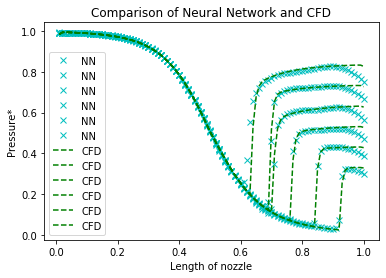

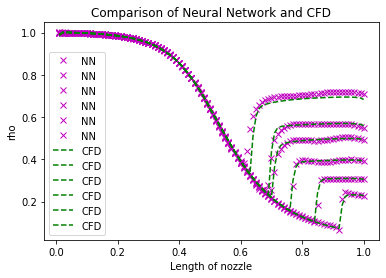

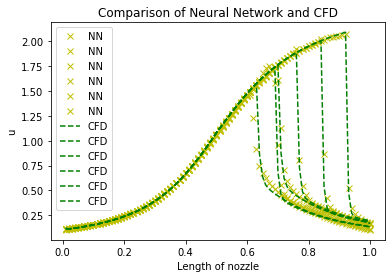

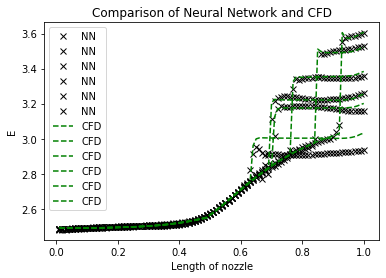

In [18]:
    #Plotting
    data_plt_1 = range(300, 400)
    data_plt_2 = range(1300, 1400)
    data_plt_3 = range(2300, 2400)
    data_plt_4 = range(3300, 3400)
    data_plt_5 = range(4300, 4400)
    data_plt_6 = range(5300, 5400)
    data_plt = list(data_plt_1) + list(data_plt_2) + list(data_plt_3) + list(data_plt_4) + list(data_plt_5) + list(data_plt_6)
    # x
    x_test_plt = data[data_plt, 0:1].flatten()[:,None]
    P_back_test_plt = data[data_plt, 1:2].flatten()[:,None]
    # y
    P_test_plt = data[data_plt, 2:3].flatten()[:,None]
    rho_test_plt = data[data_plt, 6:7].flatten()[:,None]
    u_test_plt = data[data_plt, 7:8].flatten()[:,None]
    E_test_plt = data[data_plt, 8:9].flatten()[:,None]
    # predict
    P_pred_plt, rho_pred_plt, u_pred_plt, E_pred_plt = model.predict(P_back_test_plt, x_test_plt)
    # plot P
    plt.plot(x_test_plt[0:100]/100.0, P_pred_plt[0:100], 'cx', x_test_plt[100:200]/100.0, P_pred_plt[100:200], 'cx',
        x_test_plt[200:300]/100.0, P_pred_plt[200:300], 'cx', x_test_plt[300:400]/100.0, P_pred_plt[300:400], 'cx',
        x_test_plt[400:500]/100.0, P_pred_plt[400:500], 'cx', x_test_plt[500:600]/100.0, P_pred_plt[500:600], 'cx', label='NN')
    plt.plot(x_test_plt[0:100]/100.0, P_test_plt[0:100], 'g--', x_test_plt[100:200]/100.0, P_test_plt[100:200], 'g--',
        x_test_plt[200:300]/100.0, P_test_plt[200:300], 'g--', x_test_plt[300:400]/100.0, P_test_plt[300:400], 'g--',
        x_test_plt[400:500]/100.0, P_test_plt[400:500], 'g--', x_test_plt[500:600]/100.0, P_test_plt[500:600], 'g--', label='CFD')
    plt.legend()
    plt.title('Comparison of Neural Network and CFD')
    plt.xlabel('Length of nozzle')
    plt.ylabel('Pressure*')
    plt.show()
    # plot rho
    plt.plot(x_test_plt[0:100]/100.0, rho_pred_plt[0:100], 'mx', x_test_plt[100:200]/100.0, rho_pred_plt[100:200], 'mx',
        x_test_plt[200:300]/100.0, rho_pred_plt[200:300], 'mx', x_test_plt[300:400]/100.0, rho_pred_plt[300:400], 'mx',
        x_test_plt[400:500]/100.0, rho_pred_plt[400:500], 'mx', x_test_plt[500:600]/100.0, rho_pred_plt[500:600], 'mx', label='NN')
    plt.plot(x_test_plt[0:100]/100.0, rho_test_plt[0:100], 'g--', x_test_plt[100:200]/100.0, rho_test_plt[100:200], 'g--',
        x_test_plt[200:300]/100.0, rho_test_plt[200:300], 'g--', x_test_plt[300:400]/100.0, rho_test_plt[300:400], 'g--',
        x_test_plt[400:500]/100.0, rho_test_plt[400:500], 'g--', x_test_plt[500:600]/100.0, rho_test_plt[500:600], 'g--', label='CFD')
    plt.legend()
    plt.title('Comparison of Neural Network and CFD')
    plt.xlabel('Length of nozzle')
    plt.ylabel('rho')
    plt.show()
    # plot u
    plt.plot(x_test_plt[0:100]/100.0, u_pred_plt[0:100], 'yx', x_test_plt[100:200]/100.0, u_pred_plt[100:200], 'yx',
        x_test_plt[200:300]/100.0, u_pred_plt[200:300], 'yx', x_test_plt[300:400]/100.0, u_pred_plt[300:400], 'yx',
        x_test_plt[400:500]/100.0, u_pred_plt[400:500], 'yx', x_test_plt[500:600]/100.0, u_pred_plt[500:600], 'yx', label='NN')
    plt.plot(x_test_plt[0:100]/100.0, u_test_plt[0:100], 'g--', x_test_plt[100:200]/100.0, u_test_plt[100:200], 'g--',
        x_test_plt[200:300]/100.0, u_test_plt[200:300], 'g--', x_test_plt[300:400]/100.0, u_test_plt[300:400], 'g--',
        x_test_plt[400:500]/100.0, u_test_plt[400:500], 'g--', x_test_plt[500:600]/100.0, u_test_plt[500:600], 'g--', label='CFD')
    plt.legend()
    plt.title('Comparison of Neural Network and CFD')
    plt.xlabel('Length of nozzle')
    plt.ylabel('u')
    plt.show()
    # plot E
    plt.plot(x_test_plt[0:100]/100.0, E_pred_plt[0:100], 'kx', x_test_plt[100:200]/100.0, E_pred_plt[100:200], 'kx',
        x_test_plt[200:300]/100.0, E_pred_plt[200:300], 'kx', x_test_plt[300:400]/100.0, E_pred_plt[300:400], 'kx',
        x_test_plt[400:500]/100.0, E_pred_plt[400:500], 'kx', x_test_plt[500:600]/100.0, E_pred_plt[500:600], 'kx', label='NN')
    plt.plot(x_test_plt[0:100]/100.0, E_test_plt[0:100], 'g--', x_test_plt[100:200]/100.0, E_test_plt[100:200], 'g--',
        x_test_plt[200:300]/100.0, E_test_plt[200:300], 'g--', x_test_plt[300:400]/100.0, E_test_plt[300:400], 'g--',
        x_test_plt[400:500]/100.0, E_test_plt[400:500], 'g--', x_test_plt[500:600]/100.0, E_test_plt[500:600], 'g--', label='CFD')
    plt.legend()
    plt.title('Comparison of Neural Network and CFD')
    plt.xlabel('Length of nozzle')
    plt.ylabel('E')
    plt.show()

*plt_u and plt_l are the upper and lower bounds of a visualizaing window respectively. This defines a specific set of inputs for which the results will be plotted (it is impossible to visualize all 6100 data points at the same time).*

Again, we predict the output values for the specific input window. We now plot the predicted ouputs by the network against the actual ground truth values by CFD using MatPlotlib.

## That is it! Play with parameters and see the results..

# THANK YOU